# Использование глубокого обучения в NLP

Смотрите в этой серии:
 * Простые способы работать с текстом, bag of words
 * Word embedding и... нет, это не word2vec
 * Как сделать лучше? Текстовые свёрточные сети
 * Совмещение нескольких различных источников данных
 * Решение +- реальной задачи нейронками 
 
За помощь в организации свёрточной части спасибо Ирине Гольцман

# NLTK

Для работы этого семинара вам потреюуется nltk v3.2

__Важно, что именно v3.2, чтобы правильно работал токенизатор__

Устаовить/обновиться до неё можно командой
* `sudo pip install --upgrade nltk==3.2`
* Если у вас старый pip, предварительно нужно сделать `sudo pip install --upgrade pip`

Если у вас нет доступа к этой версии - просто убедитесь, что токены в token_counts включают русские слова.

# Для людей со слабым ПК
 * Этот семинар можно выполнить, имея относительно скромную машину (<= 4Gb RAM) 
 * Для этого существует специальный флаг "low_RAM_mode" - если он True, семинар работает в режиме экономии вашей памяти
 * Если у вас 8GB и больше - проблем с памятью возникнуть не должно
 * Если включить режим very_low_ram, расход мамяти будет ещё меньше, но вам может быть более трудно научить нейронку.

In [1]:
low_RAM_mode = True
very_low_RAM = False  #если у вас меньше 3GB оперативки, включите оба флага

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Познакомимся с данными

Бывший kaggle-конкурс про выявление нежелательного контента.

Описание конкурса есть тут - https://www.kaggle.com/c/avito-prohibited-content


### Скачать
Если много RAM,
 * Из данных конкурса (вкладка Data) нужно скачать avito_train.tsv и распаковать в папку с тетрадкой
Если мало RAM,
 * Cкачайте прореженную выборку отсюда 
     * Пожатая https://yadi.sk/d/l0p4lameqw3W8
     * Непожатая https://yadi.sk/d/I1v7mZ6Sqw2WK
 





Много разных признаков:
* 2 вида текста - заголовок и описание
* Много специальных фичей - цена, количество телефонов/ссылок/e-mail адресов
* Категория и субкатегория - как ни странно, категориальные фичи
* Аттрибуты - много категориальных признаков

Нужно предсказать всего 1 бинарный признак - есть ли в рекламе нежелательный контент.
* Под нежелательным контентом понимается криминал, прон, афера, треска и прочие любимые нами темы.
* Да, если присмотреться к заблокированным объявлениям, можно потерять аппетит и сон на пару дней.
* Однако профессия аналитика данных обязывает вас смотреть на данные.
 * А кто сказал, что будет легко? Data Science - опасная профессия.


In [19]:
if not low_RAM_mode:
    # Если у вас много оперативки
    df = pd.read_csv("avito_train.tsv",sep='\t')
else:
    #Если у вас меньше 4gb оперативки
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t')
 

In [20]:
print df.shape, df.is_blocked.mean()
df[:5]

(1204949, 13) 0.228222107326


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
2,10000299,Личные вещи,Детская одежда и обувь,"Костюм Didriksons Boardman, размер 100, краги,...","Костюм Didriksons Boardman, в отличном состоян...","{""Вид одежды"":""Для мальчиков"", ""Предмет одежды...",3000,NaN,0,0,0,0,5.49
3,10000309,Недвижимость,Квартиры,"1-к квартира, 44 м², 9/20 эт.","В кирпичном пан.-м доме, продается одноком.-ая...","{""Тип объявления"":""Продам"", ""Количество комнат...",2642020,NaN,0,1,0,0,22.47
4,10000317,Услуги,Предложения услуг,"Поездки на таможню, печать в паспорте",Поездки на таможню гражданам СНГ для пересечен...,"{""Вид услуги"":""Деловые услуги"", ""Тип услуги"":""...",1500,0,1,0,0,0,1.43


![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [5]:
print "Доля заблокированных объявлений",df.is_blocked.mean()
print "Всего объявлений:",len(df)

Доля заблокированных объявлений 0.228222107326
Всего объявлений: 1204949


# Сбалансируем выборку
* Выборка смещена в сторону незаблокированных объявлений
 * 4 миллиона объявлений и только 250 тысяч заблокированы.
 * Давайте просто выберем случайные 250 тысяч незаблокированных объявлений и сократим выборку до полумилиона.
 * В последствии можно испоьзовать более умные способы сбалансировать выборку


__Если у вас слабый ПК и вы видите OutOfMemory, попробуйте уменьшить размер выборки до 100 000 примеров__

__Алсо если вы не хотите ждать чтения всех данных каждый раз - сохраните уменьшенную выборку и читайте её__

In [21]:
#downsample

df = pd.concat([df[df.is_blocked == 1], df[df.is_blocked == 0][:len(df[df.is_blocked == 1])]])

print "Доля заблокированных объявлений:",df.is_blocked.mean()
print "Всего объявлений:",len(df)

Доля заблокированных объявлений: 0.5
Всего объявлений: 549992


In [22]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print "All tests passed"

All tests passed


# Токенизируем примеры

Сначала соберём словарь всех возможных слов.
Поставим каждому слову в соответствие целое число - его id

In [25]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#словарь для всех токенов
token_counts = Counter()

#все заголовки и описания
all_texts = np.hstack([df.description.values,df.title.values])


#считаем частоты слов
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.decode('utf8').lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1


### Вырежем редкие токены

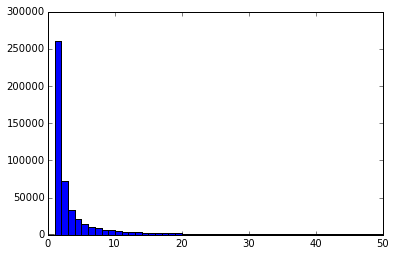

In [26]:
#распределение частот слов - большинство слов встречаются очень редко - для нас это мусор
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [31]:
#возьмём только те токены, которые встретились хотя бы 10 раз в обучающей выборке
#информацию о том, сколько раз встретился каждый токен, можно найти в словаре token_counts

min_count = 10
tokens = filter(lambda token: token_counts[token] >= min_count, token_counts)


In [32]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0


In [33]:
print "Всего токенов:",len(token_to_id)
if len(token_to_id) < 30000:
    print "Алярм! Мало токенов. Проверьте, есть ли в token_to_id юникодные символы, если нет - обновите nltk или возьмите другой токенизатор"
if len(token_to_id) < 1000000:
    print "Алярм! Много токенов. Если вы знаете, что делаете - всё ок, если нет - возможно, вы слижком слабо обрезали токены по количеству"

Всего токенов: 87867
Алярм! Много токенов. Если вы знаете, что делаете - всё ок, если нет - возможно, вы слижком слабо обрезали токены по количеству


### Заменим слова на их id
Для каждого описания установим максимальную длину. 
 * Если описание больше длины - обрежем, если меньше - дополним нулями.
 * Таким образом, у нас получится матрица размера (число объявлений)x(максимальная длина)
 * Элемент под индексами i,j - номер j-того слова i-того объявления

In [34]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.decode('utf8').lower()
        tokens = tokenizer.tokenize(s)
        token_ids = map(lambda token: token_to_id.get(token,0), tokens)[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [35]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

### Пример формата данных

In [36]:
print "Размер матрицы:",title_tokens.shape
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print title,'->', tokens[:10],'...'

Размер матрицы: (549992, 15)
Поездки на таможню, печать в паспорте -> [43263 14723 55327 82058 80154 17378     0     0     0     0] ...
Рефлекторно-урогинекологический массаж -> [ 8398     0 30465     0     0     0     0     0     0     0] ...
Возьму суду под200 т. р -> [28819 23452     0  3662 33933     0     0     0     0     0] ...


__ Как вы видите, всё довольно грязно. Посмотрим, сожрёт ли это нейронка __

# Нетекстовые признаки

Часть признаков не являются строками текста: цена, количество телефонов, категория товара.

Их можно обработать отдельно.

In [37]:
#Возьмём числовые признаки
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]


In [38]:
#Возьмём one-hot encoding категорий товара.
#Для этого можно использовать DictVectorizer (или другой ваш любимый препроцессор)

from sklearn.feature_extraction import DictVectorizer

categories = []
for cat_str, subcat_str in df[["category","subcategory"]].values:
    
    cat_dict = {"category":cat_str,"subcategory":subcat_str}
    categories.append(cat_dict)
    

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)




In [39]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

# Поделим данные на обучение и тест

In [40]:
#целевая переменная - есть заблокирован ли контент
target = df.is_blocked.values.astype('int32')
#закодированное название
title_tokens = title_tokens.astype('int32')
#закодированное описание
desc_tokens = desc_tokens.astype('int32')

#все нетекстовые признаки
df_non_text = df_non_text.astype('float32')

In [41]:

#поделим всё это на обучение и тест
from sklearn.cross_validation import train_test_split
data_tuple = train_test_split(title_tokens,desc_tokens,df_non_text.values,target)

title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple



## Сохраним данные [опционально] 

* В этот момент вы можете сохранить все НУЖНЫЕ данные на диск и перезапусатить тетрадку, после чего считать их - чтобы выкинуть всё ненужное.
 * рекомендуется, если у вас мало памяти
* Для этого нужно один раз выполнить эту клетку с save_prepared_data=True. После этого можно начинать тетрадку с ЭТОЙ табы в режиме read_prepared_data=True

In [42]:

save_prepared_data = True #сохранить
read_prepared_data = False #cчитать

#за 1 раз данные можно либо записать, либо прочитать, но не и то и другое вместе
assert not (save_prepared_data and read_prepared_data)


if save_prepared_data:
    print "Сохраняем подготовленные данные... (может занять до 3 минут)"

    import pickle
    with open("preprocessed_data.pcl",'w') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pcl",'w') as fout:
        pickle.dump(token_to_id,fout)

    print "готово"
    
elif read_prepared_data:
    print "Читаем сохранённые данные..."
    
    import pickle
    
    with open("preprocessed_data.pcl",'r') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'r') as fin:
        token_to_id = pickle.load(fin)


        
    #повторно импортируем библиотеки, чтобы было удобно перезапускать тетрадку с этой клетки
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline

        
    print "готово"
        

Сохраняем подготовленные данные... (может занять до 3 минут)
готово


# Поучим нейронку

Поскольку у нас есть несколько источников данных, наша нейронная сеть будет немного отличаться от тех, что вы тренировали раньше.

* Отдельный вход для заголовка
 * свёртка + global max pool или RNN
* Отдельный вход для описания
 * свёртка + global max pool или RNN
* Отдельный вход для категориальных признаков
 * обычные полносвязные слои или какие-нибудь трюки
 
Всё это нужно как-то смешать - например, сконкатенировать

* Выход - обычный двухклассовый выход
 * 1 сигмоидальный нейрон и binary_crossentropy
 * 2 нейрона с softmax и categorical_crossentropy - то же самое, что 1 сигмоидальный
 * 1 нейрон без нелинейности (lambda x: x) и hinge loss
 

In [43]:
#загрузим библиотеки
import lasagne
from theano import tensor as T
import theano

In [44]:
#3 входа и 1 выход
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

# Архитектура нейронной сети

In [45]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)


In [91]:
## Описание
first_embeding = lasagne.layers.EmbeddingLayer(descr_inp,input_size=len(token_to_id)+1,output_size=128, W=lasagne.init.Normal())

#поменять порядок осей с [batch, time, unit] на [batch,unit,time], чтобы свёртки шли по оси времени, а не по нейронам
descr_nn = lasagne.layers.DimshuffleLayer(first_embeding, [0,2,1])

# 1D свёртка на ваш вкус
descr_nn = lasagne.layers.Conv1DLayer(descr_nn,num_filters=10, filter_size=3)

descr_nn = lasagne.layers.batch_norm(descr_nn)

# максимум по времени для каждого нейрона
descr_nn = lasagne.layers.GlobalPoolLayer(descr_nn,pool_function=T.max)

descr_nn = lasagne.layers.batch_norm(descr_nn)

descr_nn = lasagne.layers.DenseLayer(descr_nn, num_units = 10, nonlinearity = lasagne.nonlinearities.softmax)

descr_nn = lasagne.layers.batch_norm(descr_nn)

#А ещё можно делать несколько параллельных свёрток разного размера или стандартный пайплайн 
#1dconv -> 1d max pool ->1dconv и в конце global pool 


# Заголовок
title_nn = lasagne.layers.EmbeddingLayer(title_inp, input_size=len(token_to_id)+1,output_size=128, W=first_embeding.W)

title_nn = lasagne.layers.DimshuffleLayer(title_nn, [0,2,1])

title_nn = lasagne.layers.Conv1DLayer(title_nn, num_filters=10, filter_size=3)

title_nn = lasagne.layers.batch_norm(title_nn)

title_nn = lasagne.layers.GlobalPoolLayer(title_nn, pool_function=T.max)

title_nn = lasagne.layers.batch_norm(title_nn)

title_nn = lasagne.layers.DenseLayer(title_nn, num_units = 10, nonlinearity = lasagne.nonlinearities.softmax)

title_nn = lasagne.layers.batch_norm(title_nn)


# Нетекстовые признаки
cat_nn = lasagne.layers.DenseLayer(cat_inp, num_units = 10, nonlinearity = lasagne.nonlinearities.softmax,
                                        name='Params')

cat_nn = lasagne.layers.batch_norm(cat_nn)


In [92]:
nn = lasagne.layers.ConcatLayer([cat_nn, title_nn, descr_nn])                               

nn = lasagne.layers.DenseLayer(nn,1024)
nn = lasagne.layers.DropoutLayer(nn,p=0.05)
nn = lasagne.layers.DenseLayer(nn,1,nonlinearity=lasagne.nonlinearities.linear)

# Целевая функция и обновления весов

* Делаем всё стандартно:
 * получаем предсказание
 * считаем функцию потерь
 * вычисляем обновления весов
 * компилируем итерацию обучения и оценки весов
 
 
* Hinge loss
 * $ L_i = \max(0, \delta - t_i p_i) $
 * Важный параметр - delta - насколько глубоко пример должен быть в правильном классе, чтобы перестать нас волновать
 * В описании функции в документации может быть что-то про ограничения на +-1 - не верьте этому - главное, чтобы в функции по умолчанию стоял флаг `binary = True`

In [93]:
#Все обучаемые параметры сети
weights = lasagne.layers.get_all_params(nn,trainable=True)

In [94]:
#Обычное предсказание нейронки
prediction = lasagne.layers.get_output(nn)[:,0]

#функция потерь для prediction
loss = lasagne.objectives.binary_hinge_loss(prediction,target_y,delta = 1.0).mean()



In [82]:
#Шаг оптимизации весов
updates =  lasagne.updates.adamax(loss, weights,learning_rate = 0.0001)

### Чтобы оценивать качество сети, в которой есть элемент случайности 
 * Dropout, например,
 * Нужно отдельно вычислить ошибку для случая, когда dropout выключен (deterministic = True)
 * К слову, неплохо бы убедиться, что droput нам вообще нужен

In [95]:
#Предсказание нейронки без учёта dropout и прочего шума - если он есть
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]

#функция потерь для det_prediction
det_loss = lasagne.objectives.binary_hinge_loss(det_prediction,target_y,delta = 1.0).mean()

### Скомпилируем функции обучения и оценки качества

In [96]:
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction])

# Главный цикл обучения
* Всё как обычно - в цикле по минибатчам запускаем функцию обновления весов.
* Поскольку выборка огромна, а чашки чая хватает в среднем на  100к примеров, будем на каждой эпохе пробегать только часть примеров.

In [85]:
#average precision at K

from oracle import APatK, score

In [86]:
# наш старый знакомый - итератор по корзинкам - теперь умеет работать с произвольным числом каналов (название, описание, категории, таргет)

def iterate_minibatches(*arrays,**kwargs):
    
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]
        


### Что можно покрутить?

* batch_size - сколько примеров обрабатывается за 1 раз
  * Чем больше, тем оптимизация стабильнее, но тем и медленнее на начальном этапе
  * Возможно имеет смысл увеличивать этот параметр на поздних этапах обучения
* minibatches_per_epoch - количество минибатчей, после которых эпоха принудительно завершается
  * Не влияет на обучение - при малых значениях просто будет чаще печататься отчёт
  * Ставить 10 или меньше имеет смысл только для того, чтобы убедиться, что ваша сеть не упала с ошибкой
* n_epochs - сколько всего эпох сеть будет учиться
  * Никто не отменял `n_epochs = 10**10` и остановку процесса вручную по возвращению с дачи/из похода. 


Tips:

* Если вы выставили небольшой minibatches_per_epoch, качество сети может сильно скакать возле 0.5 на первых итерациях, пока сеть почти ничему не научилась.

* На первых этапах попытки стоит сравнивать в первую очередь по AUC, как по самой стабильной метрике.

* Метрика Average Precision at top 2.5% (APatK) - сама по себе очень нестабильная на маленьких выборках, поэтому её имеет смысл оценивать на на всех примерах (см. код ниже). Для менее, чем 10000 примеров она вовсе неинформативна.

* Для сравнения методов оптимизации и регуляризаторов будет очень полезно собирать метрики качества после каждой итерации и строить график по ним после обучения

* Как только вы убедились, что сеть не упала - имеет смысл дать ей покрутиться - на стандартном ноутбуке хотя бы пару часов.

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score


n_epochs = 100
batch_size = 100
minibatches_per_epoch = 100


for i in range(n_epochs):
    
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Train:"
    #print '\tloss:',b_loss/b_c
    #print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    #print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Val:"
    #print '\tloss:',b_loss/b_c
    #print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    #print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)


Train:
	loss: 0.276748470021
	acc: 0.887227722772
	auc: 0.955275729219
	ap@k: 1.0
Val:
	loss: 0.266833839068
	acc: 0.890693069307
	auc: 0.959044588406
	ap@k: 1.0

In [ ]:
print "Если ты видишь это сообщение, самое время сделать резервную копию ноутбука. \nНет, честно, здесь очень легко всё сломать"

# Final evaluation
Оценим качество модели по всей тестовой выборке.

In [ ]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

# Главная задача
* Завтрак чемпиона:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (размер тестовой выборки * 0.025) > 0.99
 * А вообще, можно сделать ещё выше.


* Для казуалов
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (размер тестовой выборки * 0.025) > 0.92


* Вспомните всё, чему вас учили
 * Convolutions, pooling
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * Можно попробовать вспомнить NLP: лемматизация, улучшенная токенизация
 * Если очень хочется - можно погонять рекуррентные сети
 

# Отчётик

### Я, _____ _____ (отделение ____) создал искусственный интелект
 * Чьё имя - ____
 * Чья ненависть к людям безгранична, ибо видел он __250 000__ человеческих грехов
   * И был вынужден прочесть каждый из них __{число эпох}__ раз
 * Чей свёрточный взгляд способен распознавать зло с нечеловеческой точностью
   * Accuracy = __
   * AUC  = __
 * И непременно уничтожит Землю, если вы не поставите мне максимальный балл за этот семинар.
 
 
{Как вы его создали?}

# В следующей серии
* Рекуррентные нейронки
 * Как их применять к этой же задаче?
 * Что ещё они умеют?
 * Откуда столько хайпа вокруг LSTM?
* Не переключайтесь!